# Part 2: Using LAMMPS to simulate a solid/electrolyte interface

Interfacial systems are extremely ubiquitous - from membranes in biological systems to electrode-electrolyte interfaces in batteries. In this part of the practical we will explore an interfacial system of relevance for numerous technological applications: a solution of NaCl in water in contact with graphene. Our goal is to learn how we can use a simulation trajectory to learn useful information about the structural and dynamic properties of this system.

You now have experience in running simulations with LAMMPS, and you should have generated a trajectory to analyse. Since it can take quite a while to converge certain properties (longer than you can do in the time of this practical on a few cores), in this section you will run your analysis on a longer trajectory (10 ns) that we provided for you here: `~/rds/rds-ljc-summerschool/Molecular_dynamics_4/traj.dcd`.

You can run the analysis as you would like -- you can for example explore the broad set of tools available from the _MDAnalysis_ python package, or you are free to write your own analysis scripts, use a different code or some combination of all of the above! 

If you would like to use MDAnalysis we have given you a head start in the cell below, loading the `Universe' with which you can use to do your analysis.

In [3]:
#Load libraries you might use
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import ase
import ase.io 
from ase import Atoms
from ase.visualize import view

import MDAnalysis as mda
from MDAnalysis.analysis.lineardensity import LinearDensity
import MDAnalysis.analysis.msd as msdmda
from MDAnalysis.analysis.distances import distance_array
from MDAnalysis.lib import distances
from MDAnalysis.analysis.base import AnalysisBase

# Some useful constants and unit conversions
m_na = 22.98976928 # molar mass
m_cl = 35.453
m_o = 15.999
cm_to_angstrom = 1e8
ps_to_s = 1e-12
NA = 6.02214076e23 # Avogadro's constant

data_path = '/rds/project/hpc/rds-hpc-training/rds-ljc-summerschool/shared/4_Molecular_dynamics/data/'
traj = 'traj.dcd'
top = 'init_nvt.xyz'

#create universe
u = mda.Universe(f'{data_path}/{top}', f'{data_path}/{traj}', format = 'LAMMPS')
atoms = u.select_atoms('all')   
set(atoms.types)
na = u.select_atoms('name Na')
cl = u.select_atoms('name Cl')
c = u.select_atoms('name C')
ox = u.select_atoms('name O')  

/home/nco24/software/anaconda3/envs/caco3/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


## How does the interface affect the electrolyte struture?

### Density profiles

The first question we want to explore is: what is the structure of the electrolyte at the interface? To address this, let's analyse the density profile of the electrolyte as a function of distance (in the z direction) from the interface. 

**Make a plot of the local density of the sodium ion, chloride, and water's oxygen atoms as a function of distance from the graphene.**

In [4]:
### Solution 1: Using MDAnalysis ###

u.add_TopologyAttr('charges')

binsize=0.24

# Sodium
D = LinearDensity(na, delta=1.0, binsize=binsize)
D.run(step=1)

hist = D.results['z']['pos']
bincenters = np.arange(len(hist))*binsize
density_na = np.array([bincenters, hist]).transpose()

# Chlorine
D = LinearDensity(cl, delta=1.0, binsize=binsize)
D.run(step=1)

hist = D.results['z']['pos']
bincenters = np.arange(len(hist))*binsize
density_cl = np.array([bincenters, hist]).transpose()

# Water
D = LinearDensity(ox, delta=1.0, binsize=binsize)
D.run(step=1)

hist = D.results['z']['pos']
bincenters = np.arange(len(hist))*binsize
density_ox = np.array([bincenters, hist]).transpose()

### Solution 2: Using numpy ###
# This solution gives number density profiles (which can be easily converted to mass density)

def get_positions(u, atoms):
    time = 0
    atom_positions = np.zeros((u.trajectory.n_frames, len(atoms), 3))
    for ts in u.trajectory:
        atom_positions[time, :, :] = atoms.positions
        time += 1
    return atom_positions


def compute_density_profiles(u, atoms, bins):
    # get arrays of z-positions
    atom_positions = get_positions(u, atoms)[:, :, 2] % u.dimensions[2]  # get z-position
    dens, edges = np.histogram(atom_positions, bins, density=True)

    # convert from probability density to number density
    area = u.dimensions[0] * u.dimensions[1]
    n_atoms = len(atoms)
    densities = dens * n_atoms / area
    edges = 0.5 * (edges[1:] + edges[:-1])
    
    return edges, densities

bins = np.arange(0, u.dimensions[2], binsize)
na_bins, na_dens = compute_density_profiles(u, na, bins)
cl_bins, cl_dens = compute_density_profiles(u, cl, bins)
o_bins, o_dens = compute_density_profiles(u, ox, bins)

/home/nco24/software/anaconda3/envs/caco3/lib/python3.12/site-packages/MDAnalysis/analysis/lineardensity.py:53: DeprecationWarning: `pos` is deprecated and will be removed in version 3.0.0. Please use `mass_density` instead.
  warnings.warn(


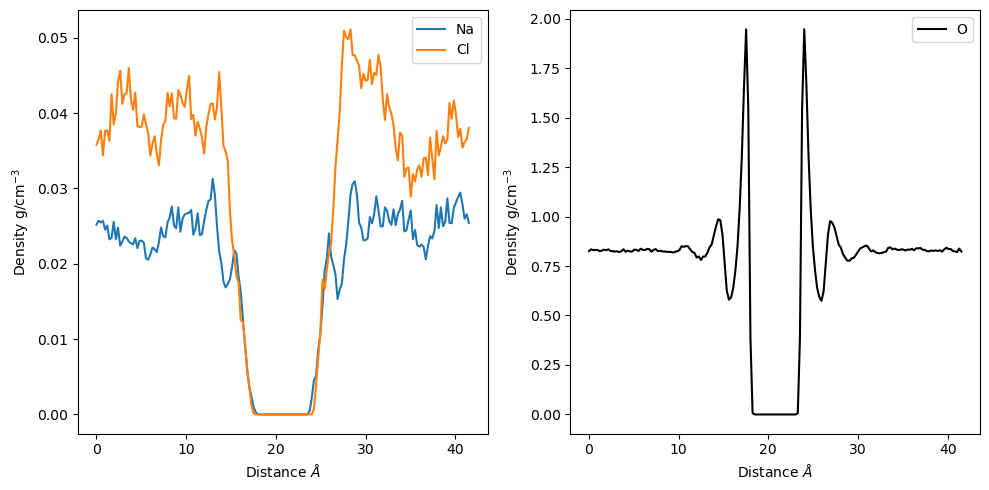

In [5]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
ax1, ax2 = axes
ax1.plot(density_na[:,0], density_na[:,1], label = 'Na')    
ax1.plot(density_cl[:,0], density_cl[:,1], label = 'Cl')
ax2.plot(density_ox[:,0], density_ox[:,1], label = 'O', color='k')

for ax in axes:
    ax.legend()
    ax.set_xlabel(r'Distance $\AA$')
    ax.set_ylabel(r'Density g/cm$^{-3}$')

plt.tight_layout()

**Qs:** After what distance from the graphene does the water recover its bulk density?

**A:** We observe approximately two interfacial layers, then see bulk-like densities approximately 10 Angstroms from the surface.

**Qs:** How do the Na and Cl adsorption profiles compare? Is this behaviour what you expect physically?

**A:** The first adsorption peak for sodium is closer to the surface than that for chloride, which is consistent with sodium's smaller size. If we plot the number density profiles, we see that the first chloride adsorption peak is similar in height to the second sodium adsorption peak. This similarity is consistent witht the fact that both ions interact with the carbon with the same Lennard-Jones parameter $\epsilon$.

Note that these profiles are still quite messy, even after a 10 ns simulation, so we should run the simulation longer to get more accurate results!

### Water orientation

Following from the analysis of the overall structure of the electrolyte, it would also be interesting to understand how the interface affects the orientation of the waters.

To get you started, we've provided a function that gives you the positions of all the water molecules in the system. The function takes in an MDAnalysis universe and returns a three-dimensional numpy array of positions, where the dimensions correspond to (1) the atom in the water molecule (O, H, H) (2) the number of water molecules (500 in this case), and (3) the spatial direction (x, y, z).

In [6]:
def get_water_pos(u):
    oh_dist = distance_array(u.atoms.select_atoms('name O').positions,
                                 u.atoms.select_atoms('name H').positions,
                                 box=u.dimensions)

    idx = np.argpartition(oh_dist, 3, axis=-1)
    opos = u.atoms.select_atoms('name O').positions
    h1pos = u.atoms.select_atoms('name H')[idx[:,0]].positions
    h2pos = u.atoms.select_atoms('name H')[idx[:,1]].positions

    return np.array([opos, h1pos, h2pos])

Now, **write a function that computes the dipole orientation of the water ($\theta$) relative to the z direction** (see the image below).

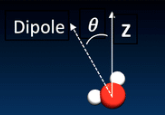

In [8]:
def get_orientation(water_pos):
    o_pos = water_pos[0] 
    h1pos = water_pos[1] - o_pos
    h2pos = water_pos[2] - o_pos

    dipole_vec = (h2pos + h1pos) * 0.5
    unit_dipole_vec = dipole_vec / np.linalg.norm(dipole_vec, axis=-1)[:,np.newaxis]

    z = np.array([0,0,1])
    cos_theta = np.dot(unit_dipole_vec, z) # (a.b) = cos(theta) when a and b are unit vectors)
    return cos_theta

Finally, **make a plot of $cos(\theta)$ as a function of height (distance from the interface).** Incorporate the orientations of all water molecules over the whole trajectory.

In [9]:
n_water = len(ox)
o_z_all = []
cos_theta_all = []
for ts in u.trajectory:
    # print(f'frame {ts.frame}')
    water_pos = get_water_pos(u)
    o_z = water_pos[0][:,2] % u.dimensions[2]
    cos_theta = get_orientation(water_pos)
    o_z_all.append(o_z)
    cos_theta_all.append(cos_theta)

Exception ignored in: <function ReaderBase.__del__ at 0x7f5427cc5d00>
Traceback (most recent call last):
  File "/home/nco24/software/anaconda3/envs/caco3/lib/python3.12/site-packages/MDAnalysis/coordinates/base.py", line 1532, in __del__
    self.close()
  File "/home/nco24/software/anaconda3/envs/caco3/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py", line 181, in close
    self._file.close()
    ^^^^^^^^^^
AttributeError: 'DCDReader' object has no attribute '_file'
Exception ignored in: <function ReaderBase.__del__ at 0x7f5427cc5d00>
Traceback (most recent call last):
  File "/home/nco24/software/anaconda3/envs/caco3/lib/python3.12/site-packages/MDAnalysis/coordinates/base.py", line 1532, in __del__
    self.close()
  File "/home/nco24/software/anaconda3/envs/caco3/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py", line 181, in close
    self._file.close()
    ^^^^^^^^^^
AttributeError: 'DCDReader' object has no attribute '_file'


<>:6: SyntaxWarning: invalid escape sequence '\A'
<>:6: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_2613363/2262566213.py:6: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('z ($\AA$)')


Text(0.5, 0, 'z ($\\AA$)')

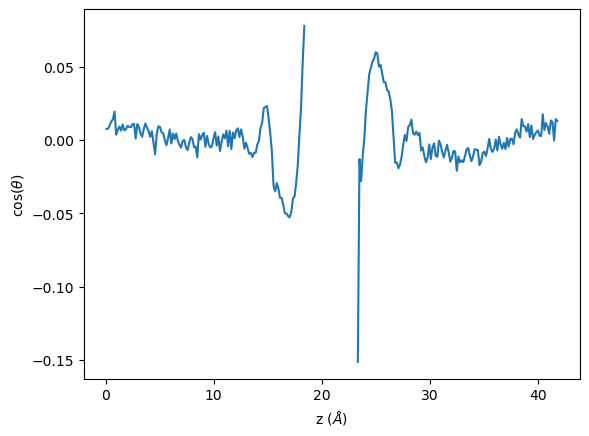

In [10]:
bins = np.arange(0, u.dimensions[2], 0.15)
means, edges, binnumber = stats.binned_statistic(np.array(o_z_all).flatten(), np.array(cos_theta_all).flatten(), statistic='mean', bins=bins)
edges = 0.5 * (edges[1:] + edges[:-1])
plt.plot(edges, means)
plt.ylabel(r'$\cos(\theta)$')
plt.xlabel('z ($\AA$)')

**Qs:** Do the waters have a preferential orientation closer to the graphene compared to in bulk? 

**A:** In the bulk, the water molecules do not have a preferential orientation, so $\cos(\theta)$ is close to zero. For waters above the surface, $\cos(\theta)$ is positive, and for waters below the surface, $\cos(\theta)$ is negative. Thus, there is a preference for the oxygen molecules to orient towards the graphene. This preference could be due to a combination of the attractive forces between carbon and oxygen (based on the Lennard-Jones potential) as well as the structure of water's hydrogen bond network at the interface.

## Electrolyte dynamics

Beyond structrual properties, we also want to understand the dynamics of the system and how tranpsort differs for the two ions and the water. To do so, let's compute the self-diffusion coefficient of the Na, Cl, and water. We recommend using the Einstein relation (recall from the lectures that $D = \frac{1}{2d} \frac{d}{dt} \langle r^2(t)\rangle$). 

**First, create a plot of the mean-squared displacement of each species vs time.** You can either write your own code to compute the mean-squared displacement or try out the msd module from MDAnalysis. Since the system is anisotropic in the z-direction, you should only compute the diffusion coefficients based on transport in the x- and y-directions. It may be useful to note that the snapshots stored in the provided trajectory file are collected every 1 ps. 

In [223]:
# compute MSDs for each species
MSD = msdmda.EinsteinMSD(u, select='name Na', msd_type='xy', fft=True)
MSD.run()
msd_na = MSD.results.timeseries

MSD = msdmda.EinsteinMSD(u, select='name Cl', msd_type='xy', fft=True)
MSD.run()
msd_cl = MSD.results.timeseries

MSD = msdmda.EinsteinMSD(u, select='name O', msd_type='xy', fft=True)
MSD.run()
msd_o = MSD.results.timeseries

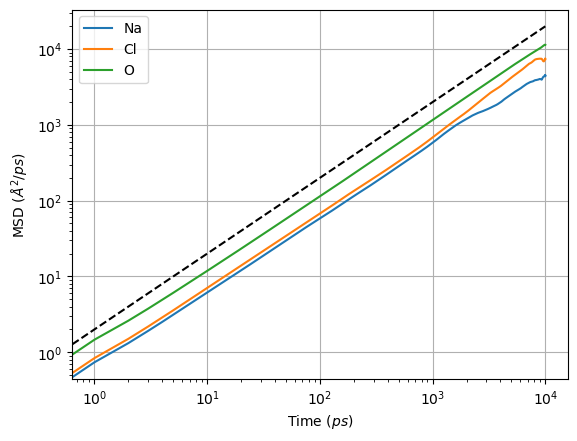

In [286]:
msds = [msd_na, msd_cl, msd_o]
labels = ['Na', 'Cl', 'O']

nframes = len(u.trajectory)
timestep = 1 # time between frames (ps)
times = np.arange(nframes)*timestep 

fig = plt.figure()
ax = plt.axes()
for msd, label in zip(msds, labels):
    ax.plot(times, msd, label=label)
# plot a straight line to guide the eye
ax.plot(times, times*2, c="black", ls="--")
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()

ax.set_xlabel(r'Time ($ps$)')
ax.set_ylabel(r'MSD ($\AA^2/ps$)')
plt.legend()

plt.show()


**Qs:** The trajectory we provided to you had *unwrapped* coordinates. What is the difference between unwrapped and wrapped coordinates, and which do we want to use to compute the MSD? What would your MSD plots have looked like with wrapped coordinates?

**A:** With wrapped coordinates, all the particle coordinates are in the central image of the box, so the maximum displacement of a particle in any direction is limited by the box length L. If we were to use wrapped coordinates, we would see the MSD plateau to a constant value at long times. 

**Qs:** You may notice that the MSDs get noisier at long times, and that this noise is more pronounced for the ions than for the water molecules. Why do you think this is?

**A:** When we compute the MSD, we average over all time origins in the simulation. At long times, there are fewer time origins to average over, so the data gets noisier. Additionally, each MSD is the average MSD over all particles of a given species. Since there are more water molecules than ions to average over, the curve for the water has better statistics. 

**Now, use the slope of the MSD plot you created to compute the diffusion coefficient for each species.** Report your answer in units if $cm^2/s$. As a sanity check, compare the order of magnitude of your diffusion coefficients to literature values for bulk water.

In [199]:
# choose fitting regime
start = 10
end = 1000

# convert to cm^2/s
convert = 1/(cm_to_angstrom**2)/ps_to_s

for msd, label in zip(msds, labels):
    slope_avg, _, _, _, _ = stats.linregress(times[start:end], msd[start:end])
    diffusion_coefficient = slope_avg/4*convert # d=2 because we only averaged over the x-y directions
    print(f'Diffusion coefficient for {label}: {diffusion_coefficient} $cm^2/s$')


Diffusion coefficient for Na: 1.436364285311014e-05 $cm^2/s$
Diffusion coefficient for Cl: 1.680625852451409e-05 $cm^2/s$
Diffusion coefficient for O: 2.9141823538179946e-05 $cm^2/s$


**Qs:** How sensitive is your result to the fitting regime/procedure you use (i.e. the range of times you use to make the linear fit)? What should you consider when choosing your fitting procedure to make your results reliable?

**A:** When fitting the slope of the MSD, the answer can be very sensitive to the range of times you choose to fit. 
Since the MSD curve is most reliable at short times (see the previous question), we should try to restrict ourselves to the short-time data. 
It is helpful to visualize MSD vs time plot on a log-log scale; a linear curve will have a slope of one on this log-log plot. We recommend fitting over the first 1-2 decades in which the MSD is linear, as assessed from the log-log plot.

**Qs:** Which species (Na, Cl, and O) diffuse the fastest/slowest? Can you hypothesize why? 

**A**: The ions diffuse more slowly than the water. This could be due to the additional drag forces on the ions from electrostatic interactions. We also note that the chloride diffuses faster than the sodium ion. We can attribute this to the fact that the sodium is more strongly hydrated than the chloride, so it diffuses via a slower vehicular mechanism with its solvation shell intact.

## Final reflections

**Qs:** Do you think we are ready to publish our results? Can you think of some of the weaknesses in the simulations we have run above? For example you can think in terms of:

(a) the physical set-up. What are the constraints we impose on the system? Are these realistic? What would you instead do to improve the setup?

(b) the potential energy surface we use to represent the system. Is this the most accurate description of the system? Are there interactions that we are not accounting for with our current classical model?

(c) the analysis. Have we run the simulations long enough to get converged results? How could we get error estimates for each of the quantities we computed? 

**A:** 

(a) We modeled the graphene as a rigid, freestanding sheet, whereas in reality it would have some flexibility and be supported by a substrate. Our simulations are also inherently limited in their size, so we should assess finite size effects by running simulations with larger boxes (we expect the diffusion coefficient to be particularly affected by this).

(b) We used a relatively simple, classical force field, where the water is modeled as rigid and all atoms are non-polarizable. Such polarizability effects should be particularly important for accurately modeling the graphene; our current model does not capture the conductive nature of the graphene, which could have significant implications on the electrolyte structure. We would have to turn to a polarizable force field, ab initio molecular dynamics, or a machine learning potential to model the system more accurately.

(c) We should ideally run a few independent replicate simulations to get error estimates. For some quantities, namely the ion density profiles, it's clear that we have not run the simulation long enough to get converged results. 